    A Minimalist Computation Graph Framework 
https://github.com/davidrosenberg/mlcourse/blob/gh-pages/Notebooks/computation-graph/computation-graph-framework.ipynb

In [2]:
import numpy as np
from IPython.display import Image

We start with a completely trival example by making a computation graph with a single node,  representing a scalar value $x$. To represent $x$, we'll use a node called a "value node", since it takes no input, but its output is the value of $x$.  Later, in machine learning contexts, we'll use nodes of this type to represent inputs, outcomes, and parameters.

We will interpret this single-node computation graph as representing the function $f(x)=x$.  Thus the "graph output", i.e the scalar-valued output of the function our computation graph represents, is also the scalar $x$.  We will refer to the node whose output is the graph output as the "graph output node".  Our computation graphs are only designed to represent scalar-valued functions, since our goal is to find inputs that minimize of maximize the function, and it's not clear what that means for a vector-valued function.

We will represent value nodes by instances of the class `ValueNode`, defined below:

In [3]:
class ValueNode(object):
    """Computation graph node having no input but simply holding a value"""
    def __init__(self, node_name):
        self.node_name = node_name
        self.out = None
        self.d_out = None
    
    def forward(self):
        self.d_out = np.zeros(self.out.shape)
        return self.out
    
    def backward(self):
        return self.d_out
    
    def get_predecessors(self):
        return []
    

To give a `ValueNode` a particular output value, we directly set it.  It should always be a numpy array. For example, for a scalar value we can set it as follows:

In [4]:
x = ValueNode("x")
x.out = np.array(3)

In backpropagation, we compute the partial derivative of the graph output with respect to the outputs of every node in the graph. Every node in the graph contains an instance variable called out, witch is a numpy array representing the output of that node.

Every node also has an instance variable d_out, which during backpropagation is set to contain the partial derivatives of the graph output with respect to the entries of out of the same node. In general, a variable named d_X wil be used tO represent the derivative of the graph output with respect to X. So ir we use J to represent the sacalar-valued graph output as we commonly do, then d_out, d_x, and d_y should be undenstood to represent $\frac{\partial J}{\partial \text{out}}$, $\frac{\partial J}{\partial \text{x}}$, and $\frac{\partial J}{\partial \text{y}}$, respectively. 

 In any node, `d_out` will always be a `numpy` array of the same shape as `out`.

Backpropagation always starts by setting `d_out` for the graph output node to the scalar `1`, since it is the partial derivative of the graph output with repect to itself.

Let's do that for the node in our trivial example.  Note that for a `ValueNode`, the `backward` function just returns `d_out`.

In [5]:
x = ValueNode("x")
x.out = np.array(3) # set the value of x
print(x.forward()) # both the node output and the graph output
x.d_out = np.array(1) # initialize backpropagation
print(x.backward()) # the partial derivative of the graph output w.r.t. the output of x

3
1


Implementation of $ f(x) = x^2 $

Let's now consider our first nontrivial function: $f(x)=x^2$.
The scalar value of the graph output will be $ J = f(x) $. An illustration of a computation graph for this function is shown bellow.

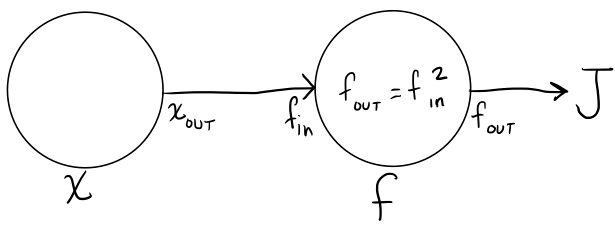

In [8]:
Image("images/comp-graph-xSquared.png")

Note that $f_{in}$ and $x_{out}$ are always equal in this graph, so you may be wondering why we give two separate names. In more complicated graphs (such as our next example), $x_{out}$ may serve as input to multiple nodes, ande we will neeed to consider that happens when we change $f_{in}$ independently of the oter node inputs connected to $x_{out}$. 

To represent this computation graph in code, we will use two nodes. The first node will be the same ValueNode x defined abobe. For the second node, f, we will create a new node type for the squaring computation. The code is as follows:

In [6]:
class SquareNode(object):
    """Node for squaring a scalar"""
    def __init__(self, x, node_name):
        """
         Parameters:
        :param x: a node producing a scalar as a numpy array
        :param node_name: node's name (string)
        """
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.x = x # Store a reference to node providing input to this node
        
    def forward(self):
        self.out = self.x.out ** 2
        self.d_out = np.zeros(self.out.shape)
        return self.out
    
    def backward(self):
        # Preconditions: self.d_out contains the partial derivatives of the graph output w.r.t. self.out
        d_x = self.d_out*2*self.x.out
        self.x.d_out += d_x
        return self.d_out
    
    def get_predecessors(self):
        """Get ist of node's predecessors"""
        return [self.x]
            
            

Note that in the `SquareNode` object `f`, the instance variables `self.x` and `self.out` correspond to $f_\text{in}$ and $f_\text{out}$, respectively, while `self.d_out` corresponds to $\frac{\partial J}{\partial f_\text{out}}$.

Let's walk through the code for `backward`.  First, before `backward` is called, we assume that `self.d_out` contains the value $\frac{\partial J}{\partial f_\text{out}}$.  In the first line of code of `backward`, we are doing the following computation:

$$
\frac{\partial J}{\partial f_\text{in}} = \left(\frac{\partial J}{\partial f_\text{out}}\right)\left(\frac{\partial f_\text{out}}{\partial f_\text{in}}\right)\\ = \left(\mathtt{self.d\_out}\right)\left(2 \cdot \mathtt{self.x.out} \right)
$$

We store the resulting value in `d_x`.  Next, we increment `self.x.d_out` so that value will contain $\frac{\partial{J}}{\partial{\mathtt{x_{out}}}}$.   In this particular situation, we could also have just set `self.x.d_out = d_x`, but in cases that the node `self.x` serves as input to multiple nodes, recall that we must add up gradient contributions from all of its children.  We'll revisit this when we get to a more complicated example.

Let's now construct the computation graph and evaluate it for a particular input value.  To do this, we construct the `ValueNode` `x`, which will contain our function input, and then `SquareNode` `f`, which gets a reference to `ValueNode` `x`, which essentially "connects" the nodes.  To evaluate the graph for a particular value, we first directly set the `out` field of the `ValueNode` `x`.  Then we call `forward` on `x` and then `f`.  After this "forward pass", the `out` variable in `f`, the graph output node, will contain the graph output.


In [7]:
# Construct the computation graph
x = ValueNode("x") # a graph input node
f = SquareNode(x, "Squaring Node")  #graph output node
# Set the input value
x.out = np.array(7) 
# Compute a forward pass
x.forward() 
f.forward() # returns the graph output

49